In [ ]:
from cgeniepy.ecology import EcoModel
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

model = EcoModel("../model/muffin.u067bc.PO4Fe.main", gemflag=['biogem', 'ecogem'])
danian = EcoModel("../model/muffin.u067bc.PO4Fe.Danian/", gemflag=['biogem','ecogem'])

## counting from 0
phyto_index = np.arange(0,32)
zoo_index = np.arange(32,64)
mixo_index = np.arange(64,96)
foram_index = np.arange(96,112)

In [ ]:
temp = model.get_ts('ocn_temp')[['time (yr)', '_surT (ice-free) (C)']]
po4 = model.get_ts('ocn_PO4')[['time (yr)', 'surface (ice-free) PO4 (mol kg-1)']]
light = model.get_ts('misc_insol')[['time (yr)','mean insolation (W m-2)']]
mld = model.get_var('phys_MLD').mean(dim=['lat','lon'])
ph = model.get_ts('misc_surpH')[['time (yr)', 'mean ocean surface pH']]

diversity = np.array([99, 99, 99, 99, 99, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22])

## combine diversity with time
diversity = pd.DataFrame({'time':mld.data.time, 'diversity':diversity})

npp = model.get_var('eco2D_Uptake_Fluxes_C') * model.grid_volume().isel(zt=0) * 12.01 * 1e-18 * 365
int_npp = npp.sum(dim=['lat','lon']).data

poc_export =  model.get_ts('fexport_POC')[['time (yr)', 'global POC flux (mol yr-1)']]
poc_export['global POC flux (Pg yr-1)'] = poc_export['global POC flux (mol yr-1)'] * 12.01 * 1e-15

d13C = model.get_ts('ocn_DIC_13C')[['time (yr)', 'surface (ice-free) DIC_13C (o/oo)', 'benthic [> 2000 m] DIC_13C (o/oo)']]
d13C['delta_d13C'] = d13C['surface (ice-free) DIC_13C (o/oo)'] - d13C['benthic [> 2000 m] DIC_13C (o/oo)']

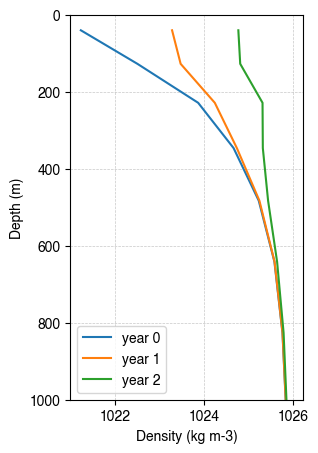

In [ ]:
density = model.get_var('misc_rho')
fig, axs= plt.subplots(1,1, figsize=(3,5))
yr0 = density.mean(dim=['lat','lon'])[3]
yr1 = density.mean(dim=['lat','lon'])[4]
yr2 = density.mean(dim=['lat','lon'])[5]

axs.plot(yr0,yr0.zt,  label='year 0')
axs.plot(yr1, yr1.zt, label='year 1')
axs.plot(yr2, yr2.zt, label='year 2')

axs.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


axs.set_ylim([0, 1000])
axs.set_xlabel('Density (kg m-3)')
axs.set_ylabel('Depth (m)')
axs.legend()
axs.invert_yaxis()
fig.savefig("../output/density_structure.png", dpi=300, bbox_inches='tight')

In [ ]:
## plot total biomass evolution
sur_vol = model.grid_volume().isel(time=0, zt=0) #m3
scale_factor = sur_vol * 12E-3 *1E-15 #mmolC/m3*m3 = mmolC => Pg C
mixo_biomass = model.get_pft(list(mixo_index+1)) * scale_factor
phyto_biomass = model.get_pft(list(phyto_index+1)) * scale_factor
zoo_biomass = model.get_pft(list(zoo_index+1)) * scale_factor
foram_biomass = model.get_pft(list(foram_index+1)) * scale_factor

mixo_biomass = mixo_biomass.sum(dim=['variable', 'lat','lon']).data
phyto_biomass = phyto_biomass.sum(dim=['variable', 'lat','lon']).data
zoo_biomass = zoo_biomass.sum(dim=['variable', 'lat','lon']).data
foram_biomass = foram_biomass.sum(dim=['variable', 'lat','lon']).data

total_biomass = mixo_biomass + phyto_biomass + zoo_biomass + foram_biomass

# total_pfts = np.zeros(len(time_steps))

# for i in range(len(time_steps)):
#     for j in range(1, len(carbon_thresholds)):
#         pft_ij = model.get_pft(j).isel(time=i)
#         threshold = carbon_thresholds[j]
#         ## filter out the species with biomass less than threshold    
#         pft_ij_presence = xr.where(pft_ij > threshold, 1, 0.0)
#         if pft_ij_presence.sum() > 0:
#             total_pfts[i] += 1
            
# ## make total_pfts a xarray
# total_pfts = xr.DataArray(total_pfts, coords=[time_steps], dims=['time'])
# total_pfts = GriddedData(total_pfts, attrs={'long_name': 'Total PFTs',  'units': 'count'})

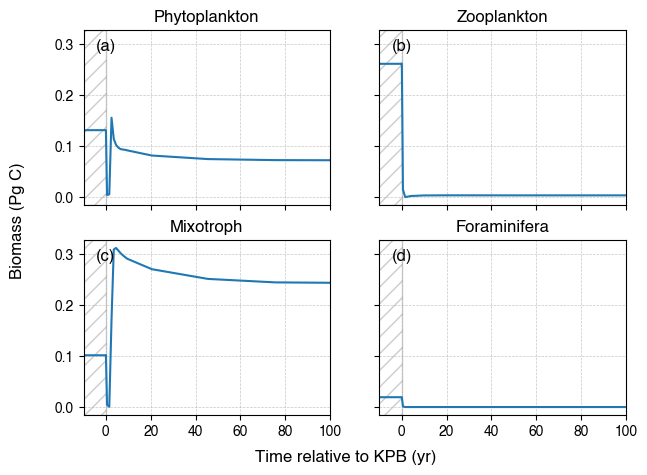

In [ ]:
# plotting the biomass for each group

fig, axs = plt.subplots(2, 2, figsize=(7,5), sharex=True, sharey=True)

axs[0,0].plot(phyto_biomass.time, phyto_biomass, label='phytoplankton')
axs[0,1].plot(zoo_biomass.time, zoo_biomass, label='zooplankton')
axs[1,0].plot(mixo_biomass.time, mixo_biomass, label='mixotrophs')
axs[1,1].plot(foram_biomass.time, foram_biomass, label='foraminifera')

import string
for ax in axs.flat:
    # add letter labels
    letter = string.ascii_lowercase[axs.flatten().tolist().index(ax)]
    ax.text(0.05, 0.95, f"({letter})", transform=ax.transAxes, va='top', fontsize=12)
    ## plot hashed area
    ax.axvspan(0, 100, facecolor='none', edgecolor='black', hatch='//', alpha=0.2)     
    ## set the range 
    ax.set_xlim(90,200)
    ## real axis ticks: 85-200
    ## axis with ticks
    ax.set_xticks(np.arange(100,201,20))
    ## change the label (minus 100 yrs)
    ax.set_xticklabels(np.arange(0,101,20))

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

fig.supxlabel('Time relative to KPB (yr)')
fig.supylabel('Biomass (Pg C)')

axs[0,0].set_title('Phytoplankton')
axs[0,1].set_title('Zooplankton')
axs[1,0].set_title('Mixotroph')
axs[1,1].set_title('Foraminifera')

fig.savefig("../output/biomass_evolution.png", dpi=300, bbox_inches='tight')

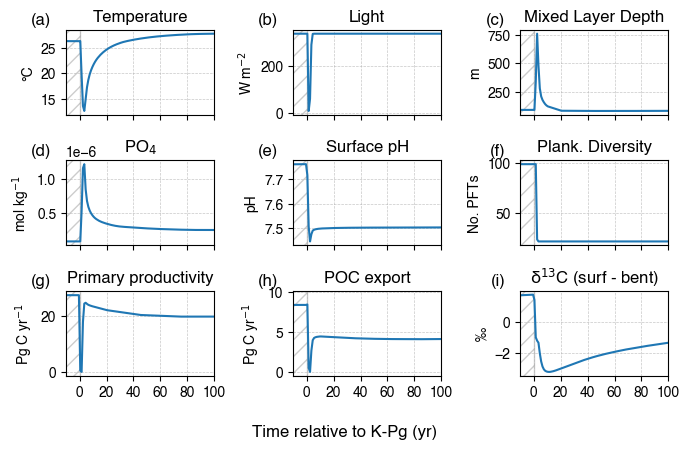

In [ ]:
fig ,axs = plt.subplots(3,3, tight_layout=True, figsize=(7,4.5), sharex=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

axs[0,0].plot(temp['time (yr)'], temp['_surT (ice-free) (C)'])
axs[0,0].set_title('Temperature')
axs[0,0].set_ylabel('°C')

axs[1,0].plot(po4['time (yr)'], po4['surface (ice-free) PO4 (mol kg-1)'])
axs[1,0].set_title(r'PO$_4$')
axs[1,0].set_ylabel(r'mol kg$^{-1}$')

axs[0,1].plot(light['time (yr)'], light['mean insolation (W m-2)'])
axs[0,1].set_title('Light')
axs[0,1].set_ylabel(r'W m$^{-2}$')

axs[0,2].plot(mld.data.time, mld.data.values)
axs[0,2].set_title('Mixed Layer Depth')
axs[0,2].set_ylabel('m')

axs[1,1].plot(ph['time (yr)'], ph['mean ocean surface pH'])
axs[1,1].set_title('Surface pH')
axs[1,1].set_ylabel('pH')

axs[1,2].plot(diversity['time'], diversity['diversity'])
axs[1,2].set_title('Plank. Diversity')
axs[1,2].set_ylabel('No. PFTs')

# axs[1,2].plot(total_biomass.time, total_biomass.values)
# axs[1,2].set_title('Total Biomass')
# axs[1,2].set_ylabel('Pg C')

axs[2,0].plot(int_npp.time, int_npp.values)
axs[2,0].set_title('Primary productivity')
axs[2,0].set_ylabel(r'Pg C yr$^{-1}$')

axs[2,1].plot(poc_export['time (yr)'], poc_export['global POC flux (Pg yr-1)'])
axs[2,1].set_title('POC export')
axs[2,1].set_ylabel(r'Pg C yr$^{-1}$')

axs[2,2].plot(d13C['time (yr)'], d13C['delta_d13C'])
axs[2,2].set_title(r'δ$^{13}$C (surf - bent)')
axs[2,2].set_ylabel('‰')

import string
## change time ticks, 0,200 to -100,100
for ax in axs.flatten():
    # ax.set_xticks(np.arange(0,201,50))
    # ax.set_xticklabels(np.arange(-100,101,50))
    # ax.set_xlim(50,200)
    ax.set_xlim(90,200)
    ## real axis ticks: 90-200
    ## axis with ticks
    ax.set_xticks(np.arange(100,201,20))
    ## change the label (minus 100 yrs)
    ax.set_xticklabels(np.arange(0,101,20))

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ## label the subplot by letters
    letter = string.ascii_lowercase[axs.flatten().tolist().index(ax)]
    ax.text(-0.1, 1.2, f"({letter})", transform=ax.transAxes, fontsize=12, va='top', ha='right')        
    ax.axvspan(0, 100, facecolor='none', edgecolor='black', hatch='//', alpha=0.2) 

## set fig. f limits
axs[1,2].set_ylim(0, 100)

fig.supxlabel('Time relative to K-Pg (yr)')
fig.savefig('../output/fig1.png', dpi=300, bbox_inches='tight')

In [ ]:
from palettable.colorbrewer.qualitative import Dark2_3, Set1_3
from palettable.cartocolors.qualitative import Vivid_3
colors = Dark2_3.mpl_colors  # list of 3 RGB tuples


## plot in one figure
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# load your models
noextinction   = EcoModel("../model/muffin.u067bc.PO4Fe.noextinction/",   gemflag=['biogem','ecogem'])
no_size_effect = EcoModel("../model/muffin.u067bc.PO4Fe.size_effect/",    gemflag=['biogem','ecogem'])
model_solar = EcoModel("../model/muffin.u067bc.PO4Fe.solar/", gemflag=['biogem','ecogem'])
model_co2 = EcoModel("../model/muffin.u067bc.PO4Fe.CO2/", gemflag=['biogem','ecogem'])


# extract & convert your timeseries
def get_poc_export(model):
    df = model.get_ts('fexport_POC')[['time (yr)', 'global POC flux (mol yr-1)']].copy()
    df['global POC flux (Pg yr-1)'] = (
        df['global POC flux (mol yr-1)'] * 12.01 * 1e-15
    )
    return df

def get_d13C_gradient(model):
    d13C = model.get_ts('ocn_DIC_13C')
    d13C['gradient'] = d13C['surface (ice-free) DIC_13C (o/oo)'] - d13C['benthic [> 2000 m] DIC_13C (o/oo)']
    return d13C[['time (yr)', 'gradient']]

poc_default      = get_poc_export(model)
poc_noextinct    = get_poc_export(noextinction)
poc_no_size_eff  = get_poc_export(no_size_effect)

d13C_default     = get_d13C_gradient(model)
d13C_noextinct   = get_d13C_gradient(noextinction)
d13C_no_size_eff = get_d13C_gradient(no_size_effect)

poc_co2 = get_poc_export(model_co2)
poc_solar = get_poc_export(model_solar)

d13C_co2 = get_d13C_gradient(model_co2)
d13C_solar = get_d13C_gradient(model_solar)

In [ ]:
poc_default

,time (yr),global POC flux (mol yr-1),global POC flux (Pg yr-1)
0,0.5,8.092514e+14,9.719109
1,1.5,7.344065e+14,8.820222
2,2.5,7.257808e+14,8.716627
3,3.5,7.203058e+14,8.650873
4,4.5,7.166934e+14,8.607488
...,...,...,...
195,195.5,3.448824e+14,4.142038
196,196.5,3.450069e+14,4.143533
197,197.5,3.450277e+14,4.143783
198,198.5,3.451539e+14,4.145298


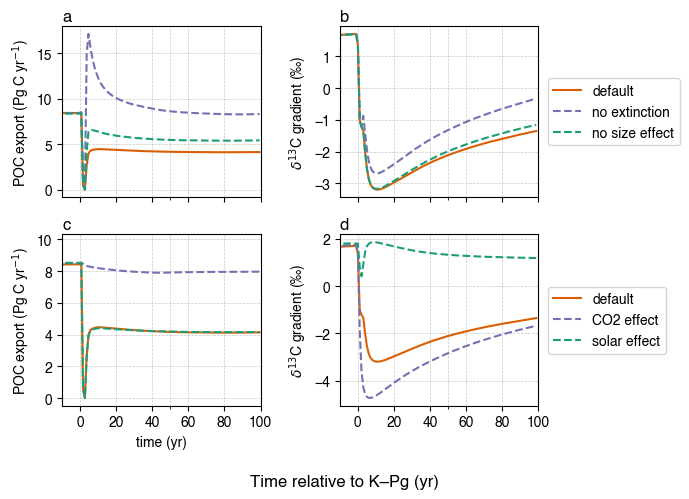

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define color palettes
colors_row1 = Dark2_3.mpl_colors
colors_row2 = Dark2_3.mpl_colors

# Define datasets and styles
row1_data = {
    "default":       {"poc": poc_default,       "d13C": d13C_default,       "style": "-",  "color": colors_row1[1]},
    "no extinction": {"poc": poc_noextinct,     "d13C": d13C_noextinct,     "style": "--", "color": colors_row1[2]},
    "no size effect":{"poc": poc_no_size_eff,   "d13C": d13C_no_size_eff,   "style": "--", "color": colors_row1[0]},
}

row2_data = {
    "default":       {"poc": poc_default,       "d13C": d13C_default,       "style": "-",  "color": colors_row2[1]},
    "CO2 effect":    {"poc": poc_co2,           "d13C": d13C_co2,           "style": "--", "color": colors_row2[2]},
    "solar effect":  {"poc": poc_solar,         "d13C": d13C_solar,         "style": "--", "color": colors_row2[0]},
}

fig, axs = plt.subplots(figsize=(7, 5), ncols=2, nrows=2,
                        sharex=True, tight_layout=True)

# Plot Row 1
for label, info in row1_data.items():
    info["poc"].plot(x='time (yr)', y='global POC flux (Pg yr-1)',
                     ax=axs[0, 0], label=label,
                     linestyle=info["style"], color=info["color"])
    info["d13C"]['gradient'].plot(x='time (yr)',
                                  ax=axs[0, 1], label=label,
                                  linestyle=info["style"], color=info["color"])

# Plot Row 2
for label, info in row2_data.items():
    info["poc"].plot(x='time (yr)', y='global POC flux (Pg yr-1)',
                     ax=axs[1, 0], label=label,
                     linestyle=info["style"], color=info["color"])
    info["d13C"]['gradient'].plot(x='time (yr)',
                                  ax=axs[1, 1], label=label,
                                  linestyle=info["style"], color=info["color"])

# Global axis formatting
for ax in axs.flat:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    #ax.axvspan(0, 100, facecolor='none', edgecolor='black', hatch='//', alpha=0.2)

axs[0,0].set_xlim(90, 200)
axs[0,0].set_xticks(np.arange(100, 201, 20))
axs[0,0].set_xticklabels(np.arange(0, 101, 20))
axs[0,0].set_xlabel("")

# Y-axis labels
axs[0,0].set_ylabel('POC export (Pg C yr$^{-1}$)')
axs[1,0].set_ylabel('POC export (Pg C yr$^{-1}$)')
axs[0,1].set_ylabel(r"$\delta^{13}$C gradient (‰)")
axs[1,1].set_ylabel(r"$\delta^{13}$C gradient (‰)")

# Add legends outside the right of second column in each row
axs[0,1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)
axs[1,1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

## remove the first column legend
axs[0,0].legend().remove()
axs[1,0].legend().remove()

## add letter labels
import string
for ax in axs.flat:
    letter = string.ascii_lowercase[axs.flatten().tolist().index(ax)]
    ax.text(0.0, 1.1, f"{letter}", transform=ax.transAxes, va='top', fontsize=12)


fig.supxlabel('Time relative to K–Pg (yr)')
fig.savefig('../output/poc_export_noextinction_pretty.png', dpi=300, bbox_inches='tight')
plt.show()